### House Pricing Kaggle
*Author: Bogdan Floris*<br/>
*Contact: bogdan.floris@gmail.com*<br/>
Credits to: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard<br/>
This notebook consists of two parts:
1. Exploratory data analysis and Features engineering on the Ames Housing Dataset, which contains 79 features describing every aspect of the residential homes in Ames, Iowa.
2. Multiple regression techiques used to predict the sale price of the test set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
color = sns.color_palette()
%matplotlib inline

#### Read the CSV files and get an initial intuition of how the data looks like

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Shape of the data
print("Train data shape:", df_train.shape)
print("Test data shape", df_test.shape)

Train data shape: (1460, 81)
Test data shape (1459, 80)


In [3]:
# Initial look into the train data
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Check out the columns of the data frame
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
# save the ID column
train_Id = df_train['Id']
test_Id = df_test['Id']

# drop the ID column
df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

# Shape of the data after drop
print("Train data shape:", df_train.shape)
print("Test data shape", df_test.shape)

Train data shape: (1460, 80)
Test data shape (1459, 79)


To get a fill for the data, we can create a spreadsheet with the following columns:
1. Variable - the name of the variable
2. Type - numerical or categorical
3. Segment - what the variable refers to: building, space, or location. Building refers to the physical characteristics of the building, space refers to the space properties of the house, and location to its location
4. Expectation - our expectation of how this variable will influence SalePrice: low, medium, or high.
5. Conclusion
The variables that might be most influential on SalePrice are: OverallQual, YearBuilt, TotalBsmtSF, GrLivArea.

##### Analysing SalePrice

In [6]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

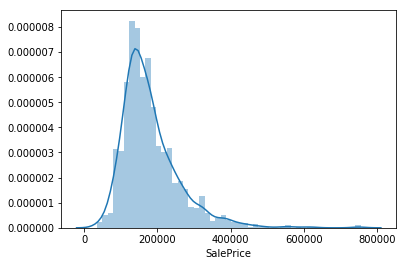

In [7]:
sns.distplot(df_train['SalePrice'])

In [8]:
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


##### Analysis of relationship between SalePrice and other variables

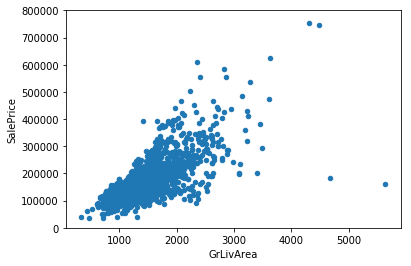

In [9]:
# scatter plot GrLivArea/SalePrice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

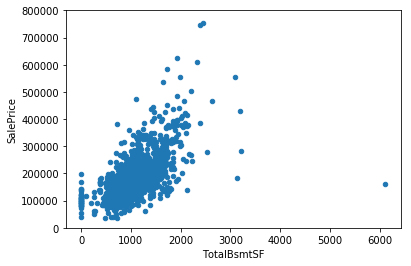

In [10]:
# scatter plot TotalBsmtSF/SalePrice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

While GrLivArea has a linear relationship with SalePrice, TotalBsmtSF is also linear but has a higher slope. Moreover, there are some values for SalePrice where TotalBsmtSF does not contribute at all. <br/>
##### Relationship with categorical variables

(-0.5, 9.5, 0, 800000)

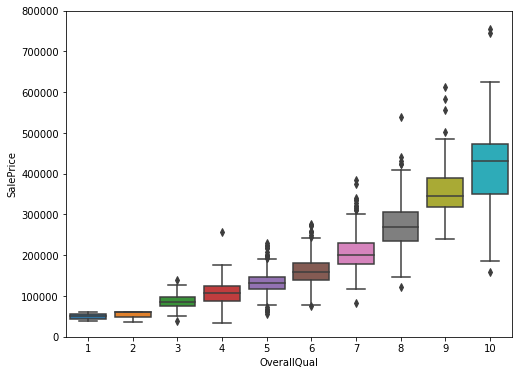

In [11]:
# box plot OverallQual/SalePrice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 <a list of 112 Text xticklabel objects>)

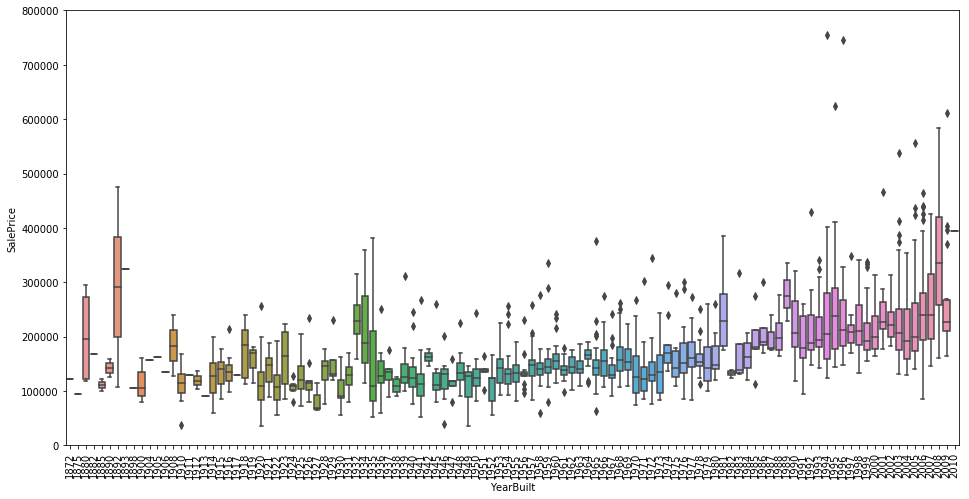

In [12]:
# box plot YearBuilt/SalePrice
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90)

SalePrice clearly increases with OverallQual, as expected. There is also a small dependency between SalePrice and YearBuilt, which makes sense given that newer houses tend to cost a little bit more (note that there are outliers here, such as houses from 1892). <br/>
##### Summary
We can conclude that all variables seem to be linearly related to SalePrice. All of them contribute to it positively, meaning that as the variables increse, so does SalePrice. The relationships seem to be stronger for OverallQuall and GrLivArea. <br/>
##### Analysing the other variables

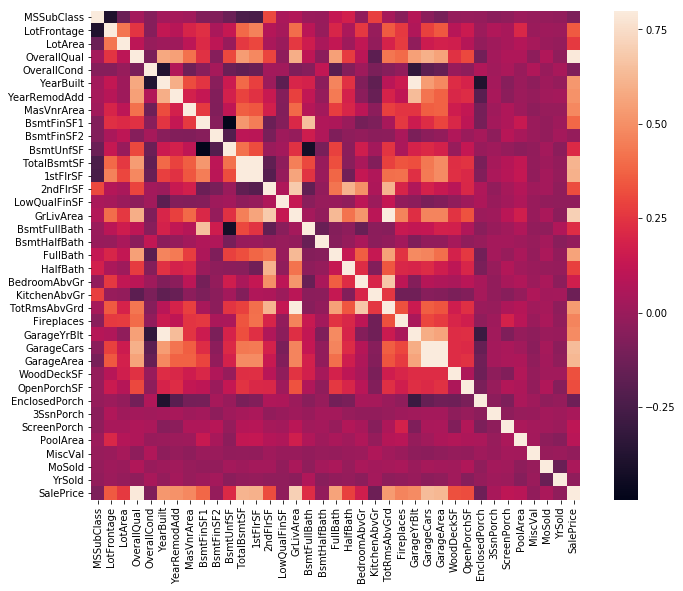

In [13]:
# correlation matrix
corr_mat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat, vmax=0.8, square=True)

The correlation between TotalBsmtSF and 1stFlrSF, and GarageCars and GarageArea is so strong that this is a situation of multicollinearity: both variables tell us the exact same information. As for the correlation with SalePrice, we can see that OverallQual, GrLivArea and TotalBsmtSF are the best predictors, but there are many others. <br/>
##### Best predictors

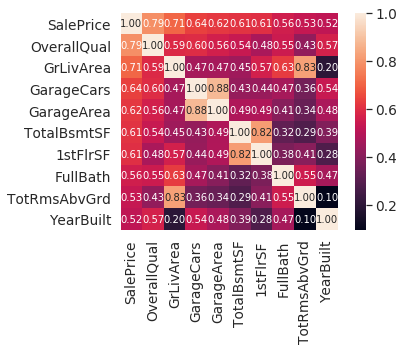

In [14]:
# SalePrice correlation matrix
k = 10
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

##### Results:
1. OverallQual, GrLivArea and TotalBsmtSF are highly correlated with SalePrice
2. GarageCars and GarageArea are basically the same so we can drop one of them. Same for TotalBsmtSF and 1stFlrSF, so we can drop 1stFlrSF

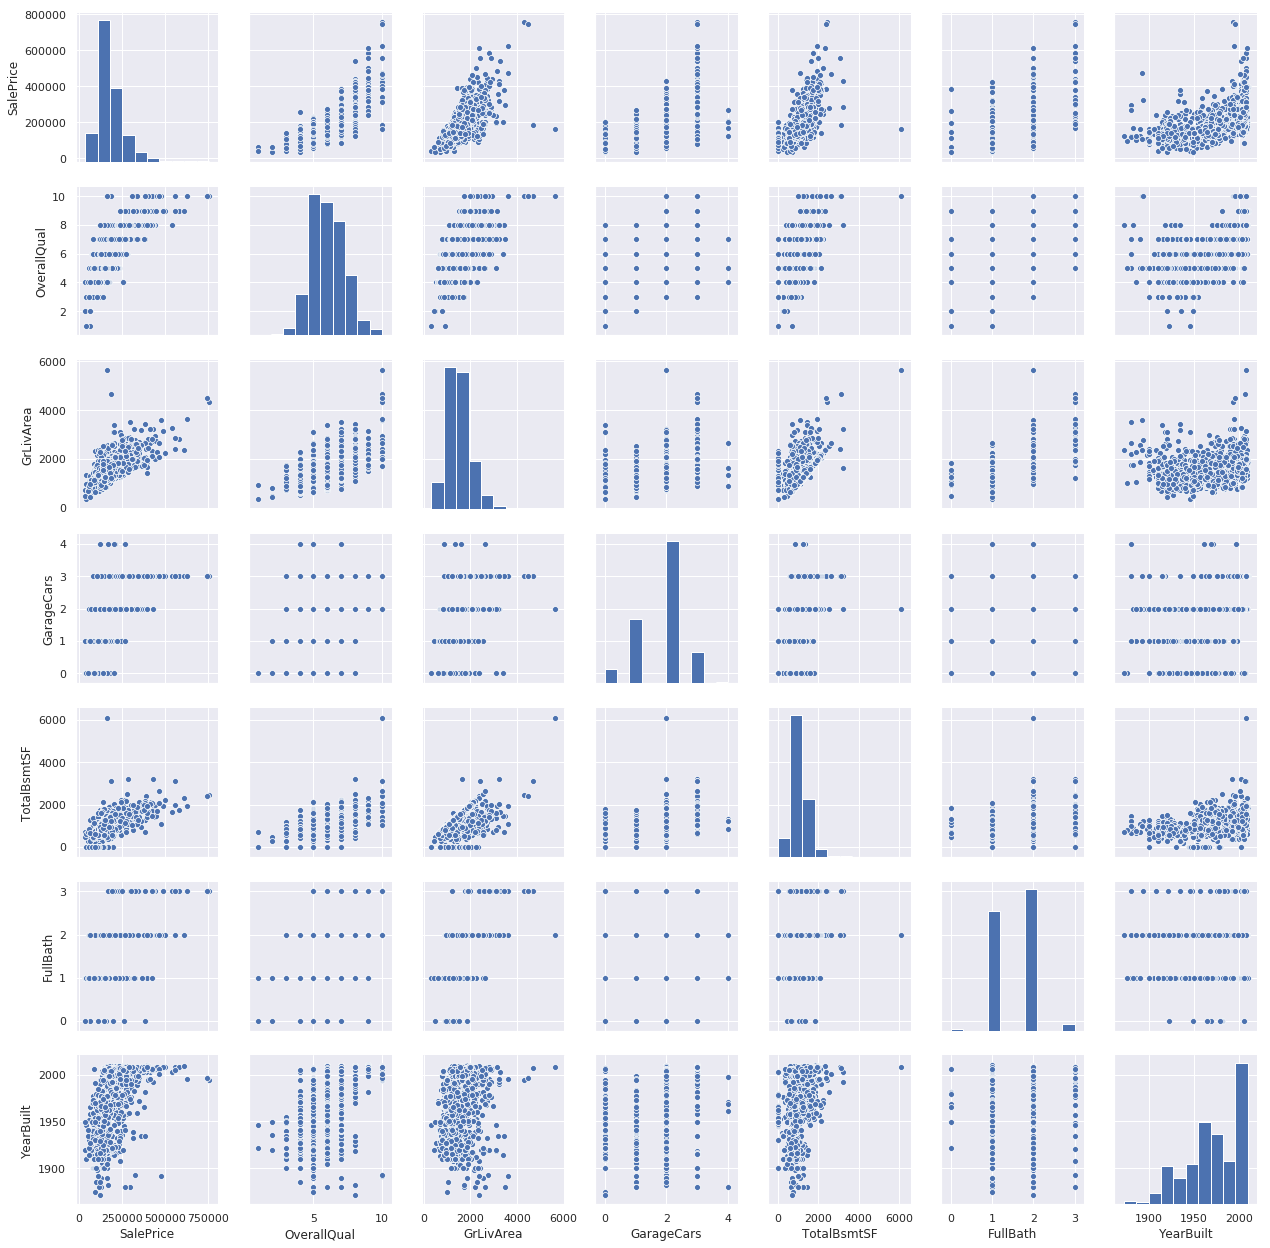

In [15]:
# scatter plots
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size=2.5)
plt.show()

##### Outliers
Univariate analysis:

In [16]:
from sklearn.preprocessing import StandardScaler
# standardizing data
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:, np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:, 0].argsort()][-10:]
print('Outer range (low) of the distribution:')
print(low_range)
print('\nOuter range (high) of the distribution:')
print(high_range)

Outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

Outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


Bivariate analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


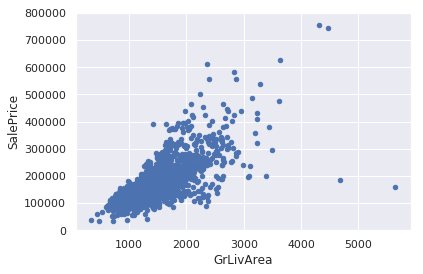

In [17]:
# Bivariate analysis SalePrice/GrLivArea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

The two points with high GrLivArea do not seem to follow the trend and we should delete them.

In [18]:
# delete points
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 250000)].index)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


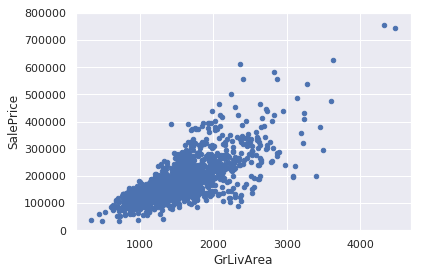

In [19]:
# scatter again for check
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


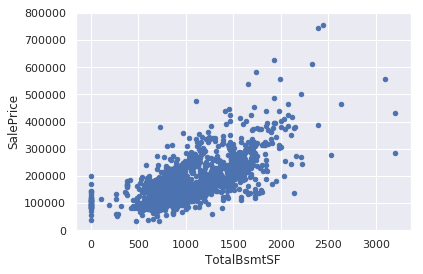

In [20]:
# Bivariate analysis SalePrice/TotalBsmtSF
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000))

#### Testing for statistical assumptions
According to the book Multivariate Data Analysis (7th Edition) by Hair et al., we have four assumptions to test:
1. Normality - whether or not the data looks like a normal distribution
2. Homoscedasticity - assumption that dependent variables exhibit equal levels of variance across the range of predictor variables (we want the error term to be the same across all values of the independent variables)
3. Linearity - whether or not the data is linear (not analysed here)
4. Abscence of correlated errors - happens when one error is correlated to another (not analysed here)

##### Normality for SalePrice

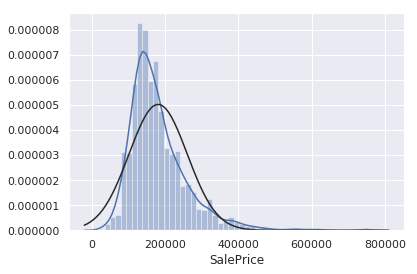

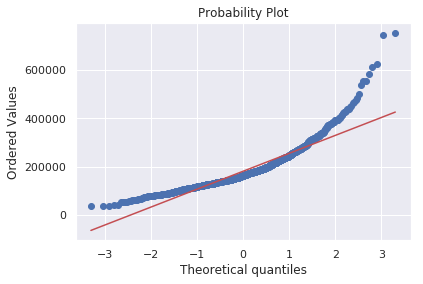

In [21]:
# histogram and QQ-plot for SalePrie
sns.distplot(df_train['SalePrice'], fit=stats.norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

SalePrice is clearly not normal because it shows peakedness, positive skewness and does not follow the normal diagonal line. In case of positive skewness, log transformations work well.

In [22]:
# apply log transformation
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

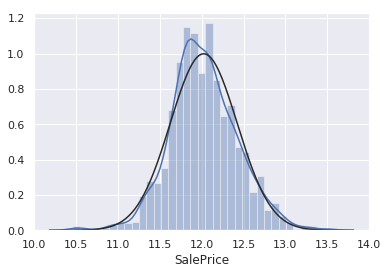

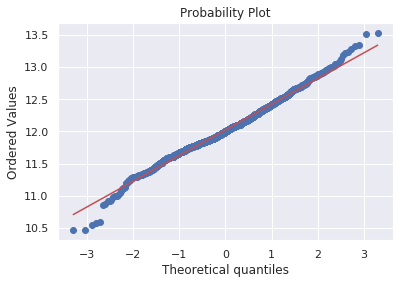

In [23]:
# histogram and QQ-plot for SalePrice again
sns.distplot(df_train['SalePrice'], fit=stats.norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

### Features engineering

##### Missing data

In [24]:
# concatanate the two data frames
n_train = df_train.shape[0]
n_test = df_test.shape[0]
y_train = df_train.SalePrice.values
df_data = pd.concat((df_train, df_test)).reset_index(drop=True)
df_data.drop(['SalePrice'], axis=1, inplace=True)
print("All data size is: {}".format(df_data.shape))

All data size is: (2917, 79)


In [25]:
total = df_data.isnull().sum().sort_values(ascending=False)
percent = (df_data.isnull().sum() / df_data.isnull().count() * 100).sort_values(ascending=False)
df_missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
df_missing_data.head(30)

,Total,Percent
PoolQC,2908,99.691464
MiscFeature,2812,96.400411
Alley,2719,93.212204
Fence,2346,80.425094
FireplaceQu,1420,48.680151
LotFrontage,486,16.660953
GarageFinish,159,5.450806
GarageQual,159,5.450806
GarageYrBlt,159,5.450806
GarageCond,159,5.450806


##### Inputting missing values

In [26]:
# PoolQC: NA means no pool, so we can fill it with none
df_data['PoolQC'] = df_data['PoolQC'].fillna('None')

In [27]:
# MiscFeature: NA means no misc feature, so we can fill it with none
df_data['MiscFeature'] = df_data['MiscFeature'].fillna('None')

In [28]:
# Alley: NA means no alley access, so we can fill it with none
df_data['Alley'] = df_data['Alley'].fillna('None')

In [29]:
# Fence: NA means no fence, so we can fill it with none
df_data['Fence'] = df_data['Fence'].fillna('None')

In [30]:
# FireplaceQu: NA means no fireplace, so we can fill it with none
df_data['FireplaceQu'] = df_data['FireplaceQu'].fillna('None')

In [31]:
# LotFrontage: numerical value, so we can fill it with the median of the neighborhood
df_data['LotFrontage'] = df_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [32]:
# GarageX categorical features: we can fill with None since there is no garage
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df_data[col] = df_data[col].fillna('None')

In [33]:
# GarageX numerical features: replace missing data with 0
# If there is no garage, then there is no year, no area and no cars in it
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_data[col] = df_data[col].fillna(0)

In [34]:
# BsmtX categorical features: no basement, so none
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df_data[col] = df_data[col].fillna('None')

In [35]:
# BsmtX numerical features: no basement, so most likely 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df_data[col] = df_data[col].fillna(0)

In [36]:
# MasVnrX: NA means no masonry veneer, so we can fill type with none and area with 0
df_data['MasVnrType'] = df_data['MasVnrType'].fillna('None')
df_data['MasVnrArea'] = df_data['MasVnrArea'].fillna(0)

In [37]:
# MSZoning
print('Most common value for MSZoning is {}, so we can input that'.format(df_data['MSZoning'].mode()[0]))
df_data['MSZoning'] = df_data['MSZoning'].fillna(df_data['MSZoning'].mode()[0])

Most common value for MSZoning is RL, so we can input that


In [38]:
# Utilities: since almost all features are AllPub, so the feature is not going to help
df_data = df_data.drop(['Utilities'], axis=1)

In [39]:
# Functional: NA means typical
df_data['Functional'] = df_data['Functional'].fillna('Typ')

In [40]:
# Electrical: one NA, set it with mode
df_data['Electrical'] = df_data['Electrical'].fillna(df_data['Electrical'].mode()[0])

In [41]:
# Kitchen Qual: same as above
df_data['KitchenQual'] = df_data['KitchenQual'].fillna(df_data['KitchenQual'].mode()[0])

In [42]:
# Exterior1st/Exterior2nd: same as above
df_data['Exterior1st'] = df_data['Exterior1st'].fillna(df_data['Exterior1st'].mode()[0])
df_data['Exterior2nd'] = df_data['Exterior2nd'].fillna(df_data['Exterior2nd'].mode()[0])

In [43]:
# SaleType: same as above
df_data['SaleType'] = df_data['SaleType'].fillna(df_data['SaleType'].mode()[0])

In [44]:
# MSSubClass: replace with None
df_data['MSSubClass'] = df_data['MSSubClass'].fillna('None')

In [45]:
# sanity check
df_data.isnull().sum().max()

0

##### Transforming numerical features to categorical ones
Some features like OverallCond or MSSubClass are numeric in the data frame, but they really represent categorical features, so we should transform them.

In [46]:
# MSSubClass, OverallCond, YrSold and MoSold are cast to strings
for col in ('MSSubClass', 'OverallCond', 'YrSold', 'MoSold'):
    df_data[col] = df_data[col].astype(str)

##### Label Encoding categorical features that may contain information in their order

In [47]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# apply LabelEncoder to the features
for col in cols:
    label_enc = LabelEncoder()
    label_enc.fit(list(df_data[col].values))
    df_data[col] = label_enc.transform(list(df_data[col].values))
# shape
print(df_data.shape)

(2917, 78)


##### New features

In [48]:
# total square footage of the house
df_data['TotalSF'] = df_data['TotalBsmtSF'] + df_data['1stFlrSF'] + df_data['2ndFlrSF']

##### Skewness
Calculate skewness for numerical features

In [49]:
# get the numerical features
numeric_features = df_data.dtypes[df_data.dtypes != 'object'].index
# calculate skewness for the features
skewness_features = df_data[numeric_features].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
# construct data frame
skewness = pd.DataFrame({'Skew': skewness_features})
skewness.head(30)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


Apply BoxCox transformation for the highly skewed features (BoxCox1P).

In [50]:
from scipy.special import boxcox1p

skewness = skewness[skewness['Skew'] > 0.75]
skewed_features = skewness.index
# remove this since it increases skewness
skewed_features = skewed_features.drop(['BsmtUnfSF'])

# copy for testing purposes (doesn't overwrite data)
# df_data_cp = df_data.copy()
# lambda used
lamb = 0.1
# counter for debugging
counter = 0
for feature in skewed_features:
    counter += 1
    df_data[feature] = boxcox1p(df_data[feature], lamb)
    skew_feature = stats.skew(df_data[feature].dropna())
    print('{} The skewness of feature {} is: {}'.format(counter, feature, skew_feature))

1 The skewness of feature MiscVal is: 5.420486147810763
2 The skewness of feature PoolArea is: 15.706121565086328
3 The skewness of feature LotArea is: -0.08067124681556812
4 The skewness of feature LowQualFinSF is: 8.668251204974835
5 The skewness of feature 3SsnPorch is: 8.88240370445684
6 The skewness of feature LandSlope is: 4.513539976990719
7 The skewness of feature KitchenAbvGr is: 3.6413670493163597
8 The skewness of feature BsmtFinSF2 is: 2.5232890079895616
9 The skewness of feature EnclosedPorch is: 1.9992775605966795
10 The skewness of feature ScreenPorch is: 2.9640043079840037
11 The skewness of feature BsmtHalfBath is: 3.7819223185916506
12 The skewness of feature MasVnrArea is: 0.5985014331969883
13 The skewness of feature OpenPorchSF is: 0.04497277631594313
14 The skewness of feature WoodDeckSF is: 0.1986667892251471
15 The skewness of feature 1stFlrSF is: 0.12915894745785575
16 The skewness of feature LotFrontage is: -0.8897987302835719
17 The skewness of feature GrLivA

##### Testing homoscedasticity

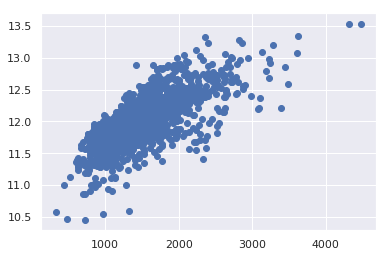

In [51]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])

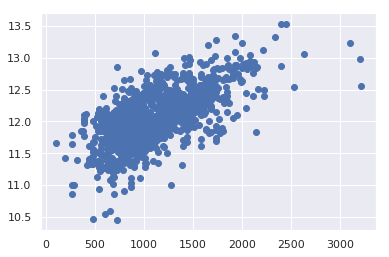

In [52]:
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice'])

Since we solved the normality problem, we also solved the homoscedasticity problem.

##### Dummy variables

In [53]:
# Convert categorical variables into dummy variables
df_data = pd.get_dummies(df_data)
print('Shape after dummy data: {}'.format(df_data.shape))

Shape after dummy data: (2917, 220)


In [54]:
# Split into train and test
df_train = df_data[:n_train]
df_test = df_data[n_train:]

### Modelling

In [55]:
# imports for modelling
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import Lasso, LassoLarsIC, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb

In [56]:
# the cross-validation strategy
n_folds = 5

def rmsle_cv(model):
    """
    Computes the K-fold RMSE for the model.
    :param model: a model that implements fit
    :return: the rmse
    """
    k_fold = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse = np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv=k_fold))
    return rmse

##### Lasso regression
Sensitive to outliers, so we use RobustScaler before.

In [57]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

In [58]:
score = rmsle_cv(lasso)
print('Lasso score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Lasso score: 0.1106 (0.0072)


##### ElasticNet
Same as Lasso. The l1_ratio does not contribute that much to the model, after some experiments.

In [59]:
elastic_net = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=0.8, random_state=2))

In [60]:
score = rmsle_cv(elastic_net)
print('ElasticNet score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

ElasticNet score: 0.1106 (0.0072)


##### Gradient Boosting Regression

In [112]:
g_boost = GradientBoostingRegressor(loss='huber', learning_rate=0.05, n_estimators=500,
                                    subsample=0.8, min_samples_split=10, min_samples_leaf=15,
                                    max_depth=5, max_features='sqrt', random_state=42)

In [113]:
score = rmsle_cv(g_boost)
print('Gradient Boosting score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

Gradient Boosting score: 0.1154 (0.0078)


##### XGBoost

In [65]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [66]:
score = rmsle_cv(model_xgb)
print('XGBoost score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

XGBoost score: 0.1157 (0.0063)


##### LightGBM

In [67]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [68]:
score = rmsle_cv(model_lgb)
print('LightGBM score: {:.4f} ({:.4f})'.format(score.mean(), score.std()))

LightGBM score: 0.1153 (0.0070)


#### Training, Prediction and Submission

In [115]:
def rmsle(y, y_pred):
    """
    Evaluation function
    """
    return np.sqrt(mean_squared_error(y, y_pred))

In [117]:
def train_model(model):
    """
    Trains the model and returns the prediction
    on the training data and on the test data.
    :param model: Model to be trained.
    """
    model.fit(df_train.values, y_train)
    train_pred = model.predict(df_train.values)
    test_pred = np.expm1(model.predict(df_test.values))
    return (train_pred, test_pred)

In [119]:
train_pred, test_pred = train_model(g_boost)
print('Train RMSLE score: {}'.format(rmsle(y_train, train_pred)))

Train RMSLE score: 0.0727571609479254


In [120]:
# submission
submission = pd.DataFrame()
submission['Id'] = test_Id
submission['SalePrice'] = test_pred
submission.to_csv('submission.csv', index=False)